We will first load the dataset and define the target variable for the problem.
import the packages:

In [3]:
import pandas as pd
import numpy as np

To plot within notebook:

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

Setting figure size:

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

For normalizing data:

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

Read the file:

In [7]:
df = pd.read_csv('WTI_price.csv')

Print the head:

In [8]:
df.head()

,Date,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)"
0,"Jan 02, 1986",25.56
1,"Jan 03, 1986",26.00
2,"Jan 06, 1986",26.53
3,"Jan 07, 1986",25.85
4,"Jan 08, 1986",25.87


The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. 

Let’s plot the target variable to understand how it’s shaping up in our data.

Setting index as date:

In [10]:
df['Date'] = pd.to_datetime(df.Date) # ,format='%Y-%m-%d'
df.index = df['Date']

Plot:

//anaconda3/envs/inventors/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


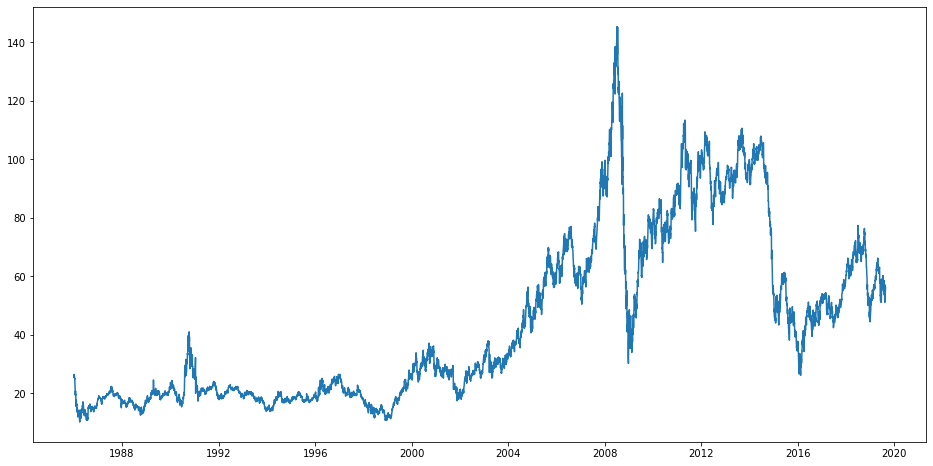

In [11]:
plt.figure(figsize=(16,8))
plt.plot(df['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'], label='Price history')

Let us go ahead and try another advanced technique – Long Short Term Memory (LSTM).
LSTMs are widely used for sequence prediction problems and have proven to be extremely effective. 
The reason they work so well is because LSTM is able to store past information that is important, and forget the information that is not. 

LSTM has three gates: The input gate: 
The input gate adds information to the cell state, 
The forget gate: It removes the information that is no longer required by the model
The output gate: Output Gate at LSTM selects the information to be shown as output

For a more detailed understanding of LSTM and its architecture, you can go through the below article: https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/


For now, let us implement LSTM as a black box and check it’s performance on our particular data.
Importing required libraries:

In [12]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.
//anaconda3/envs/inventors/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/envs/inventors/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/envs/inventors/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/envs/inventors/lib/python3.6/sit

Creating dataframe:

In [14]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'][i] = data['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'][i]

Setting index:

In [15]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

Creating train and test sets:

In [16]:
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

Converting dataset into x_train and y_train:

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

Create and fit the LSTM network:

In [18]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 63s - loss: 6.2330e-05


Predicting 246 values, using past 60 from the train data:

In [19]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Results:

//anaconda3/envs/inventors/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


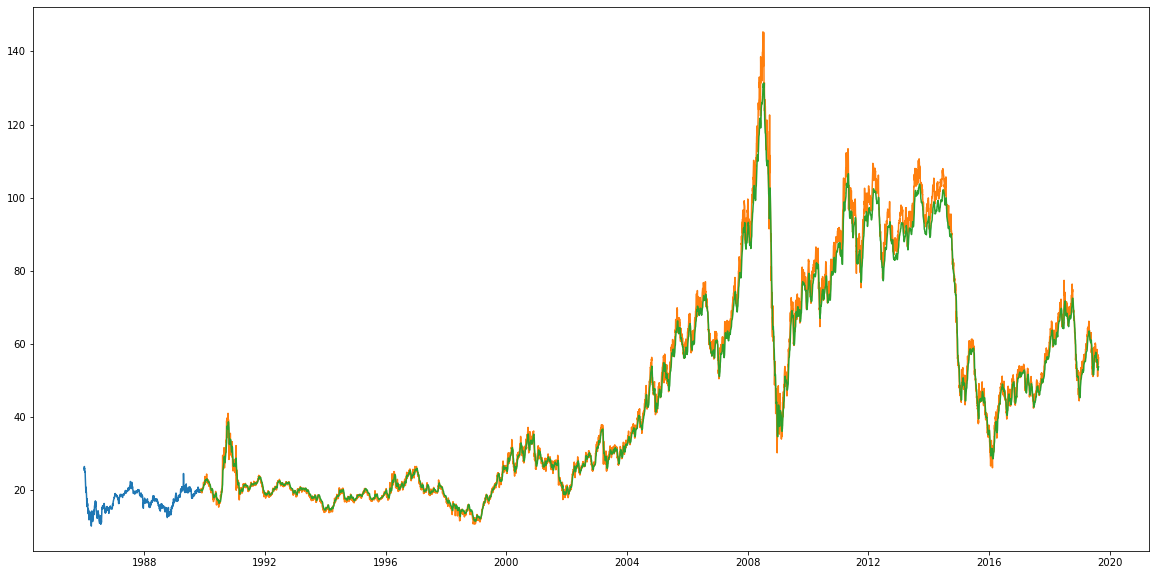

In [21]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

# Plot
train = new_data[:987]
valid = new_data[987:]
valid['Predictions'] = closing_price
plt.plot(train['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)'])
plt.plot(valid[['Cushing, OK WTI Spot Price FOB (Dollars per Barrel)','Predictions']])